To gain a better understanding of process monitoring we will build a couple of different monitoring charts in Python and discuss how they could be used for online process monitoring. 

# Shewhart chart

The Shewhart chart is a monitoring chart for process location. It can be used to determine if a process is in or out of control. Let's build one using the example data set in the file. This is the same example used in the class slides, this is just a more detailed dive into how to make the chart using Python.

In [1]:
import os
import pandas as pd
import numpy as np
data = pd.read_csv(os.getcwd() + os.sep + "rubber-colour.csv")
print(data)

    Colour
0      252
1      252
2      230
3      249
4      242
..     ...
95     245
96     231
97     238
98     246
99     241

[100 rows x 1 columns]


In this case colour of a rubber product is our variable of interest and we have them collected in a time-based order. We know from the Central Limit Theorem that the average ($\bar{x}$) of a subsample of $n$ points comes from the normal distribution with an unknown mean $\mu$ and an unknown population variance $\sigma^2_n$ with $\mu$ and $\sigma$ coming from the original distribution. Let's first calculate the averages and standard deviation of these $K$ subgroups of size $n$.

In [2]:
n = 5
x_data = np.array(data['Colour'])
x_bar = np.mean(x_data.reshape(-1, n), 1)
s_k = np.std(x_data.reshape(-1, n), 1, ddof=1)
print(x_bar)

[245.  238.6 239.4 241.  240.8 241.  237.8 237.6 235.6 248.  232.8 236.2
 246.2 253.  226.8 231.2 237.2 228.4 238.8 240.2]


Note that the above method only works if the size of the original data is divisible by $n$. If it's not, an easy method is to cut the 'extra' data points at the end. 

The next step to building the Shewhart chart is to calculate the mean of the means $\bar{\bar{x}} = \frac{1}{K}\Sigma_{k=1}^K\bar{x_k}$ and to estimate the standard deviation of the original population $\frac{\bar{S}}{a_n}$ where $\bar{S} = \frac{1}{K}\Sigma_{k=1}^Ks_k$ and $a_n$ is a correction factor based on the size of the subsample. The value of $a_n$ can be taken from the slides for the class. 

In [3]:
x_bar_bar = np.mean(x_bar)
S_bar = np.mean(s_k)
print(x_bar_bar)
print(S_bar)

238.77999999999997
9.277690126438383


Based on these values we can calculate the lower and upper control limits given by the equations:
$LCL = \bar{\bar{x}} - \frac{c_n\bar{S}}{a_n\sqrt{n}}$ and $UCL = \bar{\bar{x}} + \frac{c_n\bar{S}}{a_n\sqrt{n}}$. Where $c_n$ is the critical value taken from the normal distribution. $c_n$ in Shewhart charts is typically set to  $c_n = 3$.

In [4]:
LCL = x_bar_bar - 3*S_bar/(0.94 * np.sqrt(5))
UCL = x_bar_bar + 3*S_bar/(0.94 * np.sqrt(5))
print(LCL)
print(UCL)

225.53816225730114
252.0218377426988


The next step is to determine if any of the $K$ subsample average ($\bar{x}$) exceed these limits. 

In [5]:
data_outside_range = ((x_bar > UCL) | (x_bar < LCL)).any()
print(data_outside_range)

True


Looks like at least one of the data points are outside our control limits. Let's find the index of that point. 

In [6]:
gt_indexes, = np.where(x_bar > UCL)
lt_indexes, = np.where(x_bar < LCL)
print(gt_indexes)
print(lt_indexes)

[13]
[]


Based on the above we can see that index 13 is greater than the UCL. Let's drop it from the analysis and recalculate the limits. 

In [7]:
x_bar_new = np.delete(x_bar, 13)
s_k_new = np.delete(s_k, 13)

Let's verify that we deleted the correct limit by checking if any of the entries exceed the limits again. 

In [8]:
data_outside_range = ((x_bar_new > UCL) | (x_bar_new < LCL)).any()
print(data_outside_range)

False


We've successfully removed the outlier. Let's quickly repeat the process to calcualte our new control limits. 

In [9]:
x_bar_bar = np.mean(x_bar_new)
S_bar = np.mean(s_k_new)
LCL = x_bar_bar - 3*S_bar/(0.94 * np.sqrt(5))
UCL = x_bar_bar + 3*S_bar/(0.94 * np.sqrt(5))
print(LCL)
print(UCL)

224.21157731135617
251.8515805833806


Once again let's check to see if any of our points violate the new limits. 

In [10]:
data_outside_range = ((x_bar_new > UCL) | (x_bar_new < LCL)).any()
print(data_outside_range)

False


Great! Our new points all fall within the limits. We can now plot the Shewhart chart. We will plot it with all the historical data for illustrative purposes only. With the historic data plotted you can also clearly see the data point that we ommitted lies outside the limits.

In actuality we would only show new points on the chart. The limits of the plot are calculated with the $\bar{x}$ values and only apply to the $\bar{x}$ values. When we're using the plot online we should wait and collect $n$ new values so we can calculate the $\bar{x}$ of these values before adding the new point to the plot.

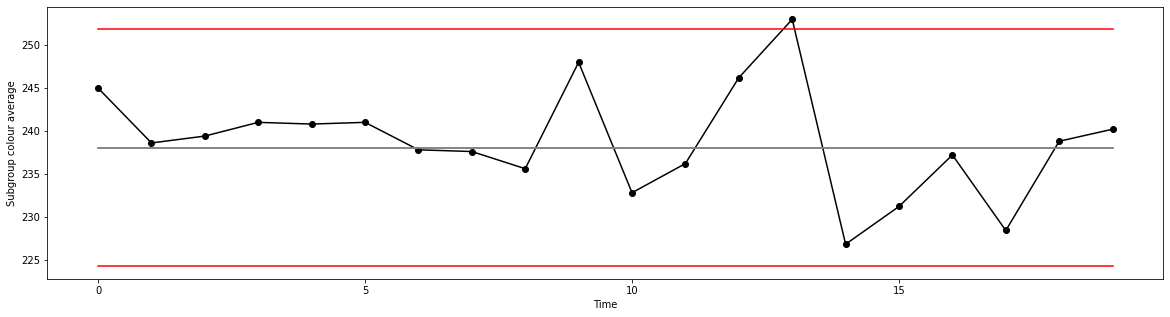

In [11]:
import matplotlib.pyplot as plt

# Change the plot size
plt.figure(figsize=(20,5))

# Add the raw data points
plt.plot(x_bar, marker='o', color='k')

# Plot the target value - assumed to be x_bar_bar in this case
target_line = [x_bar_bar]*len(x_bar)
plt.plot(target_line, color='gray')

# Add the target line
target_line = [x_bar_bar]* len(x_bar)
plt.plot(target_line, color='gray')

# Plot the control limits
UCL_line = [UCL] * len(x_bar)
LCL_line = [LCL]* len(x_bar)
plt.plot(UCL_line, color='r')
plt.plot(LCL_line, color='r')

# Format the axis
plt.xticks(range(0, len(x_bar), 5))
plt.xlabel("Time")
plt.ylabel("Subgroup colour average")
plt.show()

As discussed in the slides, warning limits are often shown at values at $c_n = \pm2$ in orange. Let's add them to the plot. 

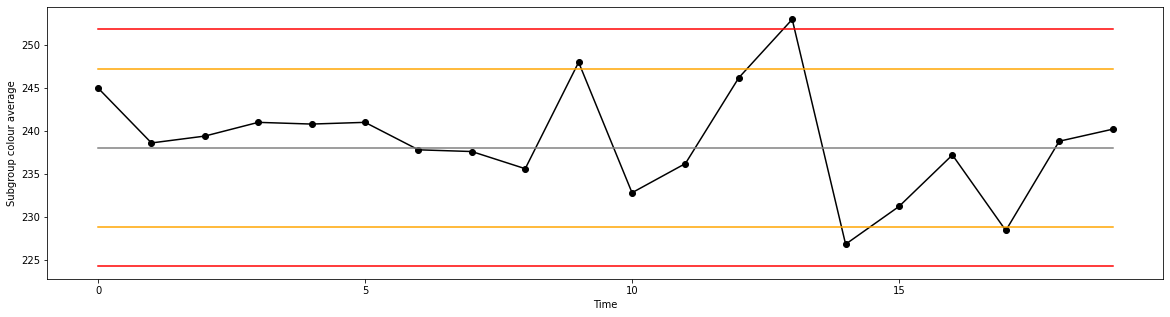

In [12]:
import matplotlib.pyplot as plt

# Change the size of the plot
plt.figure(figsize=(20,5))
# Add the main data
plt.plot(x_bar, marker='o', color='k')

# Add the UCL and LCL
UCL_line = [UCL] * len(x_bar)
LCL_line = [LCL]* len(x_bar)
plt.plot(UCL_line, color='r')
plt.plot(LCL_line, color='r')

# Add the target line
target_line = [x_bar_bar]* len(x_bar)
plt.plot(target_line, color='gray')

# Add the warning limits
upper_warning = x_bar_bar + 2*S_bar/(0.94 * np.sqrt(5))
lower_warning = x_bar_bar - 2*S_bar/(0.94 * np.sqrt(5))
upper_warning_line = [upper_warning] * len(x_bar)
lower_warning_line = [lower_warning]* len(x_bar)
plt.plot(upper_warning_line, color='orange')
plt.plot(lower_warning_line, color='orange')

# Change the axis options
plt.xticks(range(0, len(x_bar), 5))
plt.xlabel("Time")
plt.ylabel("Subgroup colour average")
plt.show()

When using the plot in an online setting we would wait to collect $n$ more measurements and average them to get a new $\bar{x}$ value to add to the plot. In the class slides we used an example that resulted in a new point $\bar{x}=245.6$, when we add this to the plot, we would add it to the right of the chart, and remove the left most point. We won't show an example of this but it would be needed to online implementation. 

# CUSUM chart

We saw in the lectures that despite being built to detect changes in location, the Shewhart chart is actually pretty slow at doing so. Let's take a look at how to calculate the values for a CUSUM chart in Python.

To build the cusum chart we calculate the cumulative sum of the deviations between our $x$ values and our target $T$. Let's take the subgroup averages from our previous examples as our $x$ data and the mean of them as our target.

In [13]:
x = np.mean(x_data.reshape(-1, n), 1)
print(x)
target = np.mean(x)
print(target)

[245.  238.6 239.4 241.  240.8 241.  237.8 237.6 235.6 248.  232.8 236.2
 246.2 253.  226.8 231.2 237.2 228.4 238.8 240.2]
238.77999999999997


To calculate the subsequent values we initialize our cumulative sum as the difference between our first data point and the target. We can then calcualte the rest of the values in a loop. We will also keep track of the CUSUM values over time with a list. In practice you don't need to store all the values in memory as your monitoring chart would be updated automatically in real time with the latest value. You would therefore only need to store the latest value in memory. 

In [14]:
# Calculate the initial sum value - S0
S_0 = x_bar[0] - target

# Store the CUSUM as a list for visualization purposes
CUSUM = [S_0]

# Loop through the time points and calculate the CUSUM value - storing it at every iteration
for i in range(1, len(x)):
    S_i = CUSUM[i-1] + (x[i] - target)
    CUSUM.append(S_i)
print(CUSUM)
    

[6.220000000000027, 6.040000000000049, 6.660000000000082, 8.88000000000011, 10.900000000000148, 13.120000000000175, 12.140000000000214, 10.960000000000235, 7.780000000000257, 17.000000000000284, 11.020000000000323, 8.440000000000339, 15.860000000000355, 30.080000000000382, 18.10000000000042, 10.520000000000437, 8.940000000000452, -1.4399999999995146, -1.419999999999476, 5.400124791776761e-13]


Now that we've calculated the CUSUM value for each time point we can plot it as a time series plot. 

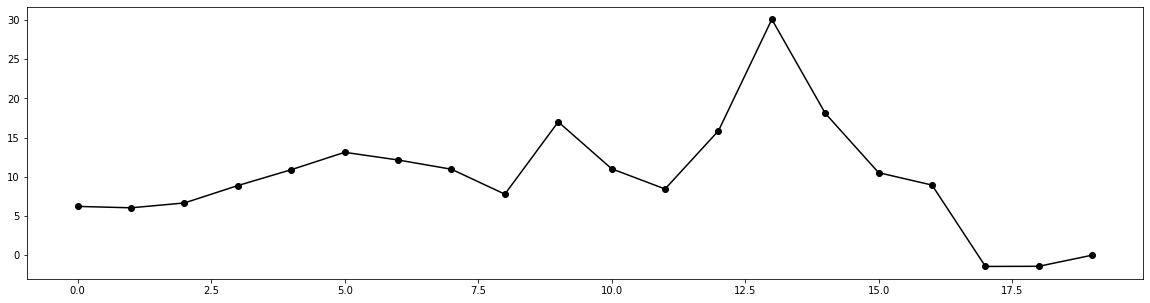

In [15]:
# Change the size of the plot
plt.figure(figsize=(20,5))
# Add the main data
plt.plot(CUSUM, marker='o', color='k')

Based on the above plot we can see that there's a fair amount of deviation to the CUSUM plot but that it comes back to the long term average of zero at the end of the horizon. The large amount of variation is also why control limits are not shown on these types of charts. 

# EWMA Chart

The Shewhart chart is a 'memoryless' chart. It assumes all incoming data points are independent. The CUSUM chart on the other hand is a 'infinite memory' chart. Error terms are accumulated since the last time the chart was reset. The Exponentially Weighted Moving Average (EWMA) chart attemps to strike a balance between the two by considering a window of memory which gives more important to current points and less to points further back in time. 

Once again, we'll look at the same example. For the EWMA chart we need to define the lambda parameter as well. Since lambda is a reserved keyword in Python we will call it scaling.

In [16]:
x = np.mean(x_data.reshape(-1, n), 1)
target = np.mean(x)
# Define lambda - can't use lambda because it's a reserved keyword in Python
scaling = 0.3

Similar to the last chart, we need a loop to calculate the values over time. Again, in an online implementation we would only need to save the previous value as the chart would be updated in real time. 

In [17]:
x_hat = [target]
for i in range(1, len(x)):
    error = x[i-1] - x_hat[i-1]
    x_hat.append(x_hat[i-1] + scaling*error)
print(x_hat)

[238.77999999999997, 240.646, 240.0322, 239.84253999999999, 240.189778, 240.3728446, 240.56099122, 239.73269385400002, 239.0928856978, 238.04501998846, 241.031513991922, 238.5620597943454, 237.85344185604177, 240.35740929922923, 244.15018650946047, 238.94513055662233, 236.62159138963563, 236.79511397274493, 234.27657978092145, 235.63360584664503]


The next step to building the EWMA chart is to calcualte the control limits. The control limits are given by the following equation: 

$CL = \bar{\bar{x}} \pm K*\sigma_{Shewhart}*\sqrt{\frac{\lambda}{2-\lambda}}$

Where the LCL is the lower value and the UCL is the higher value (governed by the $\pm$ sign). The $\sigma_{Shewhart}$ can be approximated as the mean of the standard deviations of the subgroups divided by the correction factor $a_n$.

In [18]:
s_k = np.std(x_data.reshape(-1, n), 1, ddof=1)
S_bar = np.mean(s_k)
# a_n = 0.94 for a subgroup size of 5
sigma_Shewhart = S_bar/0.94

# Calculate the Lower and Upper Control Limits
LCL = target - 3*sigma_Shewhart * np.sqrt((scaling)/(2-scaling))
UCL = target + 3*sigma_Shewhart * np.sqrt((scaling)/(2-scaling))
print(LCL)
print(UCL)

226.34145932037075
251.2185406796292


Now we can plot the EWMA chart!

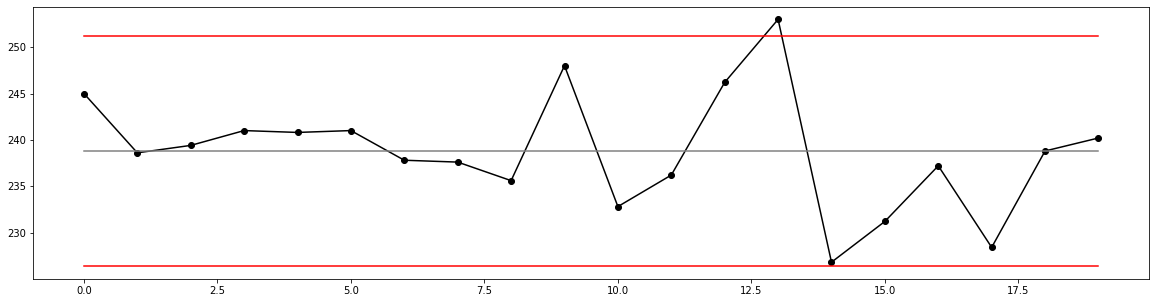

In [19]:
# Change the size of the plot
plt.figure(figsize=(20,5))
# Add the main data
plt.plot(x, marker='o', color='k')

# Add the target line
target_line = [target]* len(x)
plt.plot(target_line, color='gray')

# Add the UCL and LCL
UCL_line = [UCL] * len(x)
LCL_line = [LCL]* len(x)
plt.plot(UCL_line, color='r')
plt.plot(LCL_line, color='r')

Comparing the limits of the EWMA chart and the Shewhart chart you can see that the EWMA chart in this case has slightly tighter bounds. 

Also a disclaimer that I've mentioned already. This is what we can do to build the tests offline and test them (phase 1). To move onto phase two a more elaborate hardware and software setup is required which gets the measurements in real time (typically from a Supervisory Control and Data Acquisition System). The calculation method then changes in phase 2 because there is no need to store historical data as at each time step the chart is updated.   